# Run memento-GLM for Squair datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
import scanpy as sc
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from patsy import dmatrix, dmatrices 
import statsmodels.api as sm

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
def sample_sum(data):
    
    s = data.sum(axis=0)
    return s

def scaled_mean_se2(data, sf, q):

	augmented_data = np.append(data, np.ones((1,data.shape[1])), axis=0)

	sf = np.append(sf, sf.mean())
	q = q.mean()
	X = augmented_data/sf.reshape(-1,1)

	naive_v = X.var(axis=0)
	naive_m = X.mean(axis=0)
	v = naive_v-(1-q)*(X/(sf**2-sf*(1-q)).reshape(-1,1)).mean(axis=0)
	variance_contributions = ((1-q)/sf).reshape(-1,1)*naive_m.reshape(1,-1) + v.reshape(1,-1)
	m = np.average( X, weights=1/variance_contributions, axis=0)
	m[~np.isfinite(m)] = naive_m[~np.isfinite(m)]
	m[m<0] = 0
	# return m, v/data.shape[0]
	return m*data.sum(), (v/data.shape[0])*data.sum()**2

In [4]:
data_path = '/data_volume/r_datasets/squair/sc_rnaseq/h5Seurat/'

### Hagai 2018

In [5]:
files = [
    'Hagai2018_mouse-lps',
    'Hagai2018_mouse-pic',
    'Hagai2018_pig-lps',
    'Hagai2018_rabbit-lps',
    'Hagai2018_rat-lps',
    'Hagai2018_rat-pic',
]

In [8]:
for file in files:
    
    stim = file.split('-')[-1]

    adata = sc.read(data_path + file)
    adata.obs['q'] = 0.05
    memento.setup_memento(adata, q_column='q', trim_percent=0.05)
    
    glm_adata = adata.copy()
    dispersions = pd.read_csv('_{} .csv'.format(file))
    gene_list = dispersions['gene'].tolist()
    dispersions = dispersions['dispersion'].tolist()

    scaled_means = []
    weights = []
    meta = []
    totals = []
    
    groups = glm_adata.obs[['replicate', 'label']].drop_duplicates().reset_index()
    for idx, row in groups.iterrows():
        
        ind = row['replicate']
        condition = row['label']
        
        data = glm_adata[(glm_adata.obs['replicate']==ind) & (glm_adata.obs['label']==condition)].X.toarray()
        sf = glm_adata[(glm_adata.obs['replicate']==ind) & (glm_adata.obs['label']==condition)].obs['memento_size_factor'].values
        q = glm_adata[(glm_adata.obs['replicate']==ind) & (glm_adata.obs['label']==condition)].obs['q'].values
        totals.append(data.sum())
        s, se2 = scaled_mean_se2(data, sf, q)
        scaled_means.append(s)
        w = np.ones(s.shape[0])
        w[se2>0] = 1/se2[se2>0]
        weights.append(np.sqrt(1/se2))
        meta.append((ind, int(stim in condition)))
    scaled_means = pd.DataFrame(np.vstack(scaled_means), columns=glm_adata.var.index)
    weights = pd.DataFrame(np.vstack(weights), columns=glm_adata.var.index)
    # totals = scaled_means.sum(axis=1).values

    meta = pd.DataFrame(meta, columns=['replicate', 'label'])

    # Filter and re-order by gene_list
    scaled_means = scaled_means[gene_list]
    weights = weights[gene_list]
    weights = weights / weights.values.mean(axis=0)

    design = dmatrix('replicate+label', meta)


    weighted_mean_glm_results = []
    for idx in range(len(gene_list)):
        model = sm.GLM(
            scaled_means.iloc[:, [idx]], 
            design , 
            exposure=totals,
            var_weights=weights.iloc[:, idx],
            family=sm.families.NegativeBinomial(alpha=np.mean(dispersions)))
        res_model = sm.GLM(
            scaled_means.iloc[:, [idx]], design[:, :-1] , 
            exposure=totals,
            var_weights=weights.iloc[:, idx],
            family=sm.families.NegativeBinomial(alpha=np.mean(dispersions)))
        fit = model.fit()
        res_fit = res_model.fit()
        pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
        weighted_mean_glm_results.append((fit.params[-1], pv))
    weighted_mean_glm_results = pd.DataFrame(weighted_mean_glm_results, columns=['logFC', 'PValue'], index=gene_list)
    _, weighted_mean_glm_results['FDR'] = fdrcorrection(weighted_mean_glm_results['PValue'])
    
    weighted_mean_glm_results['gene'] = gene_list
    weighted_mean_glm_results.to_csv(data_path + '../results/{}-de_test=memento-shuffle_replicates=NO.csv'.format(file), index=False)
    
    break

<AxesSubplot: >

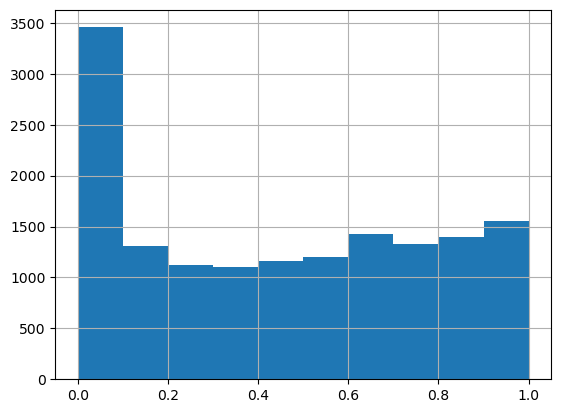

In [10]:
weighted_mean_glm_results['PValue'].hist()

In [118]:
scaled_means

In [87]:
design

In [66]:
weighted_mean_glm_results = []
for idx in range(len(gene_list)):
    model = sm.GLM(
        scaled_means.iloc[:, [idx]], 
        design , 
        exposure=totals,
        var_weights=weights.iloc[:, idx],
        family=sm.families.NegativeBinomial(alpha=0.05))
    res_model = sm.GLM(
        scaled_means.iloc[:, [idx]], design[:, :-1] , 
        exposure=totals,
        var_weights=weights.iloc[:, idx],
        family=sm.families.NegativeBinomial(alpha=0.05))
    fit = model.fit()
    res_fit = res_model.fit()
    pv = stats.chi2.sf(-2*(res_fit.llf - fit.llf), df=res_fit.df_resid-fit.df_resid)
    weighted_mean_glm_results.append((fit.params[-1], pv))
weighted_mean_glm_results = pd.DataFrame(weighted_mean_glm_results, columns=['logFC', 'PValue'], index=gene_list)
_, weighted_mean_glm_results['FDR'] = fdrcorrection(weighted_mean_glm_results['PValue'])

(array([11098.,  1306.,   936.,   750.,   708.,   625.,   601.,   588.,
          517.,   552.]),
 array([5.36163695e-91, 9.99920244e-02, 1.99984049e-01, 2.99976073e-01,
        3.99968098e-01, 4.99960122e-01, 5.99952147e-01, 6.99944171e-01,
        7.99936195e-01, 8.99928220e-01, 9.99920244e-01]),
 <BarContainer object of 10 artists>)

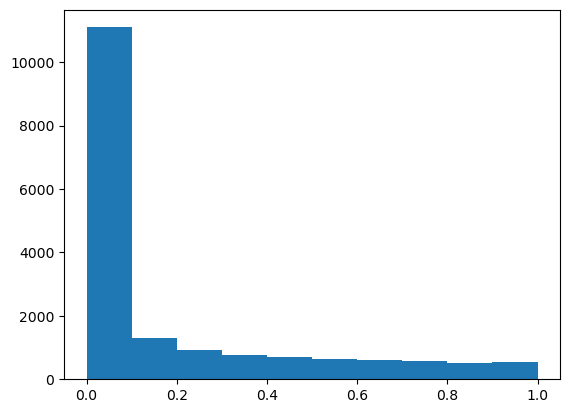

In [39]:
plt.hist(weighted_mean_glm_results['PValue'])

In [12]:
adata.obs[['replicate', 'label']].drop_duplicates().reset_index(drop=True)

,replicate,label
0,muc3838,24m
1,muc3839,24m
2,muc3840,3m
3,muc3841,3m
4,muc4166,24m
5,muc4167,24m
6,muc4168,24m
7,muc4169,3m
8,muc4170,3m
9,muc4172,3m


In [9]:
adata.obs.groupby(['replicate', 'label'])

replicate  label
muc3838    24m      155
muc3839    24m      131
muc3840    3m       293
muc3841    3m       176
muc4166    24m      252
muc4167    24m      275
muc4168    24m       99
muc4169    3m       487
muc4170    3m       364
muc4172    3m       410
muc4173    3m       583
muc4174    24m      175
muc4175    24m      103
muc4654    3m       498
muc4657    3m       198
dtype: int64